<a href="https://colab.research.google.com/github/Arefaat18/Image-Captioning/blob/master/image_captioning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
 
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
 
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
 
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import nltk
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
!git init
!git config — global user.email "ahmedrefaat0108@gmail.com"
!git config — global user.name "Arefaat18"
!git commit -m "first commit"
!git remote add origin https://<Arefaat18>:<pRIDLABL6.>ahmedrefaat0108@gmail.com/<Arefaat18>/Image-Captioning.git
!git push -u origin master

Reinitialized existing Git repository in /content/.git/
usage: git config [<options>]

Config file location
    --global              use global config file
    --system              use system config file
    --local               use repository config file
    -f, --file <file>     use given config file
    --blob <blob-id>      read config from given blob object

Action
    --get                 get value: name [value-regex]
    --get-all             get all values: key [value-regex]
    --get-regexp          get values for regexp: name-regex [value-regex]
    --get-urlmatch        get value specific for the URL: section[.var] URL
    --replace-all         replace all matching variables: name value [value_regex]
    --add                 add a new variable: name value
    --unset               remove a variable: name [value-regex]
    --unset-all           remove all matches: name [value-regex]
    --rename-section      rename section: old-name new-name
    --remove-section      rem

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 937s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [ ]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [ ]:
len(train_captions), len(all_captions)

(30000, 414113)

## Preprocess the images using the architectures


In [ ]:
def load_image_inception(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
def load_image_resnet(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, image_path

In [ ]:
def load_image_mobilenet(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    return img, image_path

In [ ]:
def load_image_vgg(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (224, 224))
  img = tf.keras.applications.vgg16.preprocess_input(img)
  print(img)

  return img, image_path

## Initialize the architectures and load the pretrained Imagenet weights


* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.


In [ ]:
#InceptionV3
image_model_inception = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input_inception = image_model_inception.input
hidden_layer_inception = image_model_inception.layers[-1].output
print(new_input_inception.shape)
print(hidden_layer_inception.shape)
image_features_extract_model_inception = tf.keras.Model(new_input_inception, hidden_layer_inception)

87916544/87910968 [==============================] - 2s 0us/step
(None, None, None, 3)
(None, None, None, 2048)


In [ ]:
#MobileNet
image_model_mobilenet = tf.keras.applications.MobileNet(include_top=False,
                                                weights='imagenet')
new_input_mobilenet = image_model_mobilenet.input
hidden_layer_mobilenet = image_model_mobilenet.layers[-14].output
print(hidden_layer_mobilenet.shape)
image_features_extract_model_mobilenet = tf.keras.Model(new_input_mobilenet, hidden_layer_mobilenet)

17227776/17225924 [==============================] - 0s 0us/step
(None, None, None, 512)


In [ ]:
#Resnet50
image_model_resnet = tf.keras.applications.resnet.ResNet50(include_top=False,
                                                weights='imagenet')
new_input_resnet = image_model_resnet.input
hidden_layer_resnet = image_model_resnet.layers[-33].output
print(len(image_model_resnet.layers))
print(new_input_resnet.shape)
print(hidden_layer_resnet.shape)
image_features_extract_model_resnet = tf.keras.Model(new_input_resnet, hidden_layer_resnet)

94773248/94765736 [==============================] - 2s 0us/step
175
(None, None, None, 3)
(None, None, None, 1024)


In [ ]:
#VGG
image_model_vgg = tf.keras.applications.VGG16(include_top=False,
                                                weights='imagenet')
new_input_vgg = image_model_vgg.input
print(new_input_vgg.shape)
hidden_layer_vgg = image_model_vgg.layers[-2].output
print(hidden_layer_vgg.shape)

image_features_extract_model_vgg = tf.keras.Model(new_input_vgg, hidden_layer_vgg)
print(image_features_extract_model_vgg)


58892288/58889256 [==============================] - 2s 0us/step
(None, None, None, 3)
(None, None, None, 512)


## Caching the features extracted from each architecture


In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))



In [ ]:
#Inception
def inception_model():
  print("INCEPTION MODEL")
  # Feel free to change batch_size according to your system configuration
  image_dataset_inception = tf.data.Dataset.from_tensor_slices(encode_train)
  image_dataset_inception = image_dataset_inception.map(
    load_image_inception, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)
  
  first = False
  for img, path in image_dataset_inception:
    batch_features_inception = image_features_extract_model_inception(img)
    if first==False:
      print(batch_features_inception.shape)
      first = True
    batch_features_inception = tf.reshape(batch_features_inception,
                                (batch_features_inception.shape[0], -1, batch_features_inception.shape[3]))

    for bf, p in zip(batch_features_inception, path):
      path_of_feature = p.numpy().decode("utf-8")
      np.save(path_of_feature, bf.numpy())

In [ ]:
#Resnet
def resnet_model():
  image_dataset_resnet = tf.data.Dataset.from_tensor_slices(encode_train)
  image_dataset_resnet = image_dataset_resnet.map(
    load_image_resnet, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

  first = False
  for img, path in image_dataset_resnet:
    batch_features_resnet = image_features_extract_model_resnet(img)
    if first==False:
      print(batch_features_resnet.shape)
      first = True
    batch_features_resnet = tf.reshape(batch_features_resnet,
                                (batch_features_resnet.shape[0], -1, batch_features_resnet.shape[3]))

    for bf, p in zip(batch_features_resnet, path):
      path_of_feature = p.numpy().decode("utf-8")
      np.save(path_of_feature, bf.numpy())

In [ ]:
#MobileNet
def mobilenet_model():
  image_dataset_mobilenet = tf.data.Dataset.from_tensor_slices(encode_train)
  image_dataset_mobilenet = image_dataset_mobilenet.map(
    load_image_mobilenet, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

  first=False
  for img, path in image_dataset_mobilenet:
    batch_features_mobilenet = image_features_extract_model_mobilenet(img)
    if first==False:
      print(batch_features_mobilenet.shape)
      first = True

    batch_features_mobilenet = tf.reshape(batch_features_mobilenet,
                                (batch_features_mobilenet.shape[0], -1, batch_features_mobilenet.shape[3]))

    for bf, p in zip(batch_features_mobilenet, path):
      path_of_feature = p.numpy().decode("utf-8")
      np.save(path_of_feature, bf.numpy())

In [ ]:
#VGG
def vgg_model():
  image_dataset_vgg = tf.data.Dataset.from_tensor_slices(encode_train)
  image_dataset_vgg = image_dataset_vgg.map(
    load_image_vgg, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

  first=False
  for img, path in image_dataset_vgg:
    batch_features_vgg = image_features_extract_model_vgg(img)
    if first==False:
      print(batch_features_vgg.shape)
      first = True
      
    batch_features_vgg = tf.reshape(batch_features_vgg,
                                (batch_features_vgg.shape[0], -1, batch_features_vgg.shape[3]))
    for bf, p in zip(batch_features_vgg, path):
      path_of_feature = p.numpy().decode("utf-8")
      np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [ ]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape_inception = 2048
attention_features_shape_inception = 64
# Shape of the vector extracted from Resnet50 is (196, 1024)
# These two variables represent that vector shape
features_shape_resnet = 1024
attention_features_shape_resnet = 196
# Shape of the vector extracted from MobileNet is (196, 512)
# These two variables represent that vector shape
features_shape_mobilenet = 512
attention_features_shape_mobilenet = 196
# Shape of the vector extracted from VGG is (196, 512)
# These two variables represent that vector shape
features_shape_vgg = 512
attention_features_shape_vgg = 196

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
def load_dataset():
  dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)

  print(dataset)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  print("LOAD DATASET")
  return dataset

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.


In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.LSTM = tf.keras.layers.LSTM(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
def loss_function(real, pred,loss_object):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
def checkpoint1():
  encoder = CNN_Encoder(embedding_dim)
  decoder = RNN_Decoder(embedding_dim, units, vocab_size)
  optimizer = tf.keras.optimizers.Adam()
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  checkpoint_path = "./checkpoints1/train"
  ckpt = tf.train.Checkpoint(encoder=encoder,
                            decoder=decoder,
                            optimizer = optimizer)
  ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
  start_epoch = 0
  if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

  # adding this in a separate cell because if you run the training cell
  # many times, the loss_plot array will be reset
  loss_plot = []

  return ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object

In [ ]:
def checkpoint2():
  encoder = CNN_Encoder(embedding_dim)
  decoder = RNN_Decoder(embedding_dim, units, vocab_size)
  optimizer = tf.keras.optimizers.Adam()
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  checkpoint_path = "./checkpoints2/train"
  ckpt = tf.train.Checkpoint(encoder=encoder,
                            decoder=decoder,
                            optimizer = optimizer)
  ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
  start_epoch = 0
  if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

  # adding this in a separate cell because if you run the training cell
  # many times, the loss_plot array will be reset
  loss_plot = []

  return ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object

In [ ]:
def checkpoint3():
  encoder = CNN_Encoder(embedding_dim)
  decoder = RNN_Decoder(embedding_dim, units, vocab_size)
  optimizer = tf.keras.optimizers.Adam()
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  checkpoint_path = "./checkpoints3/train"
  ckpt = tf.train.Checkpoint(encoder=encoder,
                            decoder=decoder,
                            optimizer = optimizer)
  ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
  start_epoch = 0
  if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

  # adding this in a separate cell because if you run the training cell
  # many times, the loss_plot array will be reset
  loss_plot = []

  return ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object

In [ ]:
def checkpoint4():
  encoder = CNN_Encoder(embedding_dim)
  decoder = RNN_Decoder(embedding_dim, units, vocab_size)
  optimizer = tf.keras.optimizers.Adam()
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  checkpoint_path = "./checkpoints4/train"
  ckpt = tf.train.Checkpoint(encoder=encoder,
                            decoder=decoder,
                            optimizer = optimizer)
  ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
  start_epoch = 0
  if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

  # adding this in a separate cell because if you run the training cell
  # many times, the loss_plot array will be reset
  loss_plot = []

  return ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object

In [ ]:
def get_train_step_fn():
  @tf.function
  def train_step(img_tensor, target,encoder,decoder,optimizer,loss_object):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    print(dec_input)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions,loss_object)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss
  return train_step

In [ ]:
def train_model(dataset,ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object,model_train_step):
  EPOCHS = 20

  for epoch in range(start_epoch, EPOCHS):
      start = time.time()
      total_loss = 0

      for (batch, (img_tensor, target)) in enumerate(dataset):
          batch_loss, t_loss = model_train_step(img_tensor, target,encoder,decoder,optimizer,loss_object)
          total_loss += t_loss

          if batch % 100 == 0:
              print ('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
      # storing the epoch end loss value to plot later
      loss_plot.append(total_loss / num_steps)

      if epoch % 5 == 0:
        ckpt_manager.save()

      print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                          total_loss/num_steps))
      print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  plt.plot(loss_plot)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Plot')
  plt.show()

In [ ]:
def evaluate_resnet(image,encoder,decoder):
    attention_plot = np.zeros((max_length, attention_features_shape_resnet))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image_resnet(image)[0], 0)
    img_tensor_val = image_features_extract_model_resnet(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def evaluate_inception(image,encoder,decoder):
    attention_plot = np.zeros((max_length, attention_features_shape_inception))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image_inception(image)[0], 0)
    img_tensor_val = image_features_extract_model_inception(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def evaluate_mobilenet(image,encoder,decoder):
    attention_plot = np.zeros((max_length, attention_features_shape_mobilenet))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image_mobilenet(image)[0], 0)
    img_tensor_val = image_features_extract_model_mobilenet(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def evaluate_vgg(image,encoder,decoder):
    attention_plot = np.zeros((max_length, attention_features_shape_vgg))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image_vgg(image)[0], 0)
    img_tensor_val = image_features_extract_model_vgg(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
#INCEPTION
def bleu_accuracy_inception(encoder,decoder):
  bleus=[]
  bleus_1=[]
  bleus_2=[]
  bleus_3=[]
  bleus_4=[]
  for rid in range(0,len(img_name_val)):
    image = img_name_val[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate_inception(image,encoder,decoder)
    bleus.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result)))
    bleus_1.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(1, 0, 0, 0)))
    bleus_2.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(0, 1, 0, 0)))
    bleus_3.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(0, 0, 1, 0)))
    bleus_4.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(0, 0, 0, 1)))
  return bleus,bleus_1,bleus_2,bleus_3,bleus_4

In [ ]:
#ResNet
def bleu_accuracy_resnet(encoder,decoder):

  bleus=[]
  bleus_1=[]
  bleus_2=[]
  bleus_3=[]
  bleus_4=[]
  for rid in range(0,len(img_name_val)):
    image = img_name_val[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate_resnet(image,encoder,decoder)
    bleus.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result)))
    bleus_1.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(1, 0, 0, 0)))
    bleus_2.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(0, 1, 0, 0)))
    bleus_3.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(0, 0, 1, 0)))
    bleus_4.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(0, 0, 0, 1)))

  return bleus,bleus_1,bleus_2,bleus_3,bleus_4

In [ ]:
#MobileNet
def bleu_accuracy_mobilenet(encoder,decoder):

  bleus=[]
  bleus_1=[]
  bleus_2=[]
  bleus_3=[]
  bleus_4=[]
  for rid in range(0,len(img_name_val)):
    image = img_name_val[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate_mobilenet(image,encoder,decoder)
    bleus.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result)))
    bleus_1.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(1, 0, 0, 0)))
    bleus_2.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(0, 1, 0, 0)))
    bleus_3.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(0, 0, 1, 0)))
    bleus_4.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(0, 0, 0, 1)))
  return bleus,bleus_1,bleus_2,bleus_3,bleus_4

In [ ]:
#VGG
def bleu_accuracy_vgg(encoder,decoder):
    
  bleus=[]
  bleus_1=[]
  bleus_2=[]
  bleus_3=[]
  bleus_4=[]
  for rid in range(0,len(img_name_val)):
    image = img_name_val[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate_vgg(image,encoder,decoder)
    bleus.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result)))
    bleus_1.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(1, 0, 0, 0)))
    bleus_2.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(0, 1, 0, 0)))
    bleus_3.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(0, 0, 1, 0)))
    bleus_4.append(nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result),weights=(0, 0, 0, 1)))

  return bleus,bleus_1,bleus_2,bleus_3,bleus_4

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
#rid=3000
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

In [ ]:
def print_bleu_score(bleus,bleus_1,bleus_2,bleus_3,bleus_4):
  print("Mean Cumulative BLEU {:4.3f}".format(np.mean(bleus)))
  print("Mean BLEU-1 {:4.3f}".format(np.mean(bleus_1)))
  print("Mean BLEU-2 {:4.3f}".format(np.mean(bleus_2)))
  print("Mean BLEU-3 {:4.3f}".format(np.mean(bleus_3)))
  print("Mean BLEU-4 {:4.3f}".format(np.mean(bleus_4)))

In [ ]:
#InceptionV3
ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object = checkpoint1()
print("k")
inception_model()
dataset = load_dataset()
model_train_step = get_train_step_fn()
train_model(dataset,ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object,model_train_step)


k
INCEPTION MODEL
(16, 8, 8, 2048)
<ParallelMapDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>
LOAD DATASET
Tensor("ExpandDims:0", shape=(64, 1), dtype=int32)
Tensor("ExpandDims:0", shape=(64, 1), dtype=int32)
Epoch 1 Batch 0 Loss 1.9746
Epoch 1 Batch 100 Loss 1.0915
Epoch 1 Batch 200 Loss 0.9353
Epoch 1 Batch 300 Loss 0.8780
Epoch 1 Loss 1.029397
Time taken for 1 epoch 381.5763783454895 sec

Epoch 2 Batch 0 Loss 0.8629
Epoch 2 Batch 100 Loss 0.8997
Epoch 2 Batch 200 Loss 0.8293
Epoch 2 Batch 300 Loss 0.7553
Epoch 2 Loss 0.791563
Time taken for 1 epoch 363.33214569091797 sec

Epoch 3 Batch 0 Loss 0.7271
Epoch 3 Batch 100 Loss 0.7641
Epoch 3 Batch 200 Loss 0.6638
Epoch 3 Batch 300 Loss 0.7269


KeyboardInterrupt: ignored

In [ ]:
result, attention_plot = evaluate_inception(image,encoder,decoder)
print("INCEPTION\n")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result))
print(BLEUscore)
inception_bleus,inception_bleus_1,inception_bleus_2,inception_bleus_3,inception_bleus_4 = bleu_accuracy_inception(encoder,decoder)

In [ ]:
print("InceptionV3 Accuracy: ")
print_bleu_score(inception_bleus,inception_bleus_1,inception_bleus_2,inception_bleus_3,inception_bleus_4)

(16, 14, 14, 512)
<ParallelMapDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>
LOAD DATASET
Tensor("ExpandDims:0", shape=(64, 1), dtype=int32)
Tensor("ExpandDims:0", shape=(64, 1), dtype=int32)
Epoch 1 Batch 0 Loss 2.1282
Epoch 1 Batch 100 Loss 1.0786
Epoch 1 Batch 200 Loss 0.9863
Epoch 1 Batch 300 Loss 0.9691
Epoch 1 Loss 1.044925
Time taken for 1 epoch 331.54515266418457 sec

Epoch 2 Batch 0 Loss 0.8096
Epoch 2 Batch 100 Loss 0.8305
Epoch 2 Batch 200 Loss 0.7978
Epoch 2 Batch 300 Loss 0.8198
Epoch 2 Loss 0.826654
Time taken for 1 epoch 312.8122184276581 sec

Epoch 3 Batch 0 Loss 0.8598
Epoch 3 Batch 100 Loss 0.7894
Epoch 3 Batch 200 Loss 0.7408
Epoch 3 Batch 300 Loss 0.7243
Epoch 3 Loss 0.754950
Time taken for 1 epoch 312.15221118927 sec

Epoch 4 Batch 0 Loss 0.6952
Epoch 4 Batch 100 Loss 0.6983
Epoch 4 Batch 200 Loss 0.6764
Epoch 4 Batch 300 Loss 0.7135
Epoch 4 Loss 0.709910
Time taken for 1 epoch 312.2485866546631 sec

Epoch 5 Batch 0 Loss 0.7289
Epoch 5 Batch

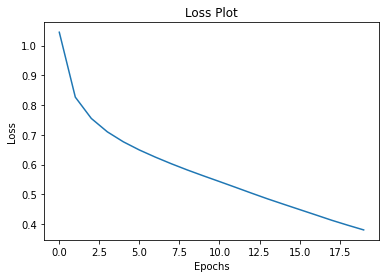

In [ ]:
#MobileNet
ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object = checkpoint3()
mobilenet_model()
dataset = load_dataset()
model_train_step = get_train_step_fn()
train_model(dataset,ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object,model_train_step)

MobileNet

Real Caption: <start> a woman and a child play with colored blocks <end>
Prediction Caption: a woman sitting in the middle of a rock <end>


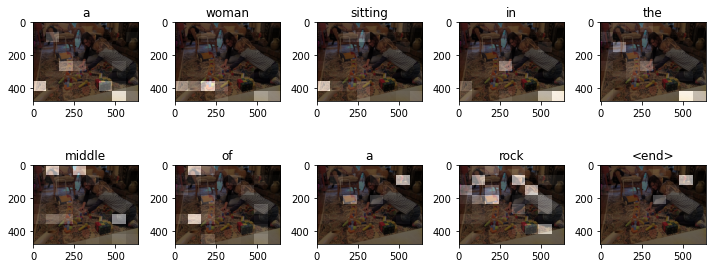

0.2757549069641312


In [ ]:
result, attention_plot = evaluate_mobilenet(image,encoder,decoder)
print("MobileNet\n")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result))
print(BLEUscore)

mobilenet_bleus,mobilenet_bleus_1,mobilenet_bleus_2,mobilenet_bleus_3,mobilenet_bleus_4 = bleu_accuracy_mobilenet(encoder,decoder)

In [ ]:
print("\nMobileNet Accuracy: ")
print_bleu_score(mobilenet_bleus,mobilenet_bleus_1,mobilenet_bleus_2,mobilenet_bleus_3,mobilenet_bleus_4)

In [ ]:
#ResNet
ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object = checkpoint4()
resnet_model()
dataset = load_dataset()
model_train_step = get_train_step_fn()
train_model(dataset,ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object,model_train_step)

(16, 14, 14, 1024)


KeyboardInterrupt: ignored

In [ ]:
result, attention_plot = evaluate_resnet(image,encoder,decoder)
print("ResNet\n")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result))
print(BLEUscore)

resnet_bleus,resnet_bleus_1,resnet_bleus_2,resnet_bleus_3,resnet_bleus_4 = bleu_accuracy_resnet(encoder,decoder)

In [ ]:
print("\nResNet Accuracy: ")
print_bleu_score(resnet_bleus,resnet_bleus_1,resnet_bleus_2,resnet_bleus_3,resnet_bleus_4)

In [ ]:
#VGG
ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object = checkpoint2()
vgg_model()
dataset = load_dataset()
model_train_step = get_train_step_fn()
train_model(dataset,ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object,model_train_step)

In [ ]:
result, attention_plot = evaluate_vgg(image,encoder,decoder)
print("VGG\n")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([real_caption], ' '.join(result))
print(BLEUscore)
vgg_bleus,vgg_bleus_1,vgg_bleus_2,vgg_bleus_3,vgg_bleus_4 = bleu_accuracy_vgg(encoder,decoder)

In [ ]:
print("\nVGG Accuracy: ")
print_bleu_score(vgg_bleus,vgg_bleus_1,vgg_bleus_2,vgg_bleus_3,vgg_bleus_4)

## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


In [ ]:
"""
ckpt_manager,start_epoch,loss_plot,encoder,decoder,optimizer,loss_object = checkpoint2()
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)


result, attention_plot = evaluate_vgg(image_path,encoder,decoder)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)

# opening the image
Image.open(image_path)
"""

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.